# Yelp Data Analysis

In [1]:
#Import all required libraries for reading data, analysing and visualizing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json

# 1) Data Preparation & Initial Analysis

### Understanding the data
Before we do any analysis, we have to understand 1) what information the data has 2) what relationship exists overall 3) what can be done with different features.
We have the following information for Yelp
    - Business - Contains business data including location data, attributes, and categories.  
    - Reviews - Contains full review text data including the user_id that wrote the review and the business_id the review is written for.  
    - User - User data including the user's friend mapping and all the metadata associated with the user.  
    - Checkin - Checkins on a business.  
    - Tips - Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.  
    - Photos - As of now, I'm going to ignore anything to do with photo identification

### 1.1 Understanding Business data

In [2]:
yelp_bdf = pd.read_json('biz.json', lines = True)
yelp_bdf.head(2)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,3101 Washington Rd,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA


### 1.1.1 Features analysis-Business
    1) the features that has nested json structures are Attributes and hours (They have nested dictionaries). So, we will have to do some data wrangling in separating out all the dictionaries and getting the correct attributes. We might bring some inference related to the attributes of the business.  
    2) categories has lists. I'm going to identify the list of categories for all the businesses and try to identify whether we can derive any relationship between different businesses & their categories.  
    3) review_count indicates the count of reviews for the specific business  
    4) stars - star rating for the business.  

In [3]:
#create different columns based on attributes and hours. The newly created columns will have a prefix of attributes. and hours.
final_df = (pd.DataFrame(yelp_bdf['attributes'].values.tolist()).add_prefix('attributes.')
.join(pd.DataFrame(yelp_bdf['hours'].values.tolist()).add_prefix('hours.'))
.join(yelp_bdf.drop(['attributes','hours'],1)))

In [4]:
final_df.head()

,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,...,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,...,Ahwatukee,1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,...,McMurray,1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Phoenix,1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,...,Tempe,0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ
4,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,"{'monday': False, 'tuesday': False, 'friday': ...",True,NaN,True,...,Cuyahoga Falls,1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH


In [5]:
#These are the only columns that doesnt have any nan values
final_df.dropna(axis=1, how='any').head(2)

,address,business_id,categories,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,3101 Washington Rd,He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA


### 1.1.2 Working on  identifying the different attributes column that has nested dictionary as well

In [6]:
final_df[['attributes.AcceptsInsurance', 'attributes.AgesAllowed',
       'attributes.Alcohol', 'attributes.Ambience', 'attributes.BYOB',
       'attributes.BYOBCorkage', 'attributes.BestNights',
       'attributes.BikeParking', 'attributes.BusinessAcceptsBitcoin',
       'attributes.BusinessAcceptsCreditCards',
       'attributes.BusinessParking', 'attributes.ByAppointmentOnly',
       'attributes.Caters', 'attributes.CoatCheck', 'attributes.Corkage',
       'attributes.DietaryRestrictions', 'attributes.DogsAllowed',
       'attributes.DriveThru', 'attributes.GoodForDancing',
       'attributes.GoodForKids']][final_df.filter(like='attributes.').notnull()].head(10)

,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking,attributes.ByAppointmentOnly,attributes.Caters,attributes.CoatCheck,attributes.Corkage,attributes.DietaryRestrictions,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForDancing,attributes.GoodForKids
0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"{'garage': False, 'street': False, 'validated'...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,"{'monday': False, 'tuesday': False, 'friday': ...",True,NaN,True,"{'garage': False, 'street': False, 'validated'...",NaN,False,False,NaN,NaN,NaN,False,False,True
5,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,NaN,NaN,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,True
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True,"{'garage': False, 'street': False, 'validated'...",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
final_df[['attributes.DietaryRestrictions']][final_df['attributes.DietaryRestrictions'].notnull()].head()

,attributes.DietaryRestrictions
101,"{'dairy-free': True, 'gluten-free': True, 'veg..."
120,"{'dairy-free': False, 'gluten-free': True, 've..."
132,"{'dairy-free': False, 'gluten-free': False, 'v..."
397,"{'dairy-free': False, 'gluten-free': False, 'v..."
432,"{'dairy-free': False, 'gluten-free': False, 'v..."


In [8]:
final_df[['attributes.GoodForMeal',
       'attributes.HairSpecializesIn', 'attributes.HappyHour',
       'attributes.HasTV', 'attributes.Music', 'attributes.NoiseLevel',
       'attributes.Open24Hours', 'attributes.OutdoorSeating',
       'attributes.RestaurantsAttire',
       'attributes.RestaurantsCounterService',
       'attributes.RestaurantsDelivery',
       'attributes.RestaurantsGoodForGroups',
       'attributes.RestaurantsPriceRange2',
       'attributes.RestaurantsReservations',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsTakeOut', 'attributes.Smoking',
       'attributes.WheelchairAccessible', 'attributes.WiFi']][final_df.filter(like='attributes.').notnull().any(1)].head()

,attributes.GoodForMeal,attributes.HairSpecializesIn,attributes.HappyHour,attributes.HasTV,attributes.Music,attributes.NoiseLevel,attributes.Open24Hours,attributes.OutdoorSeating,attributes.RestaurantsAttire,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"{'coloring': True, 'africanamerican': False, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,True,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'dessert': False, 'latenight': True, 'lunch':...",NaN,True,True,"{'dj': False, 'background_music': True, 'no_mu...",average,NaN,True,casual,NaN,False,True,2.0,False,True,True,outdoor,NaN,free
5,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,NaN,NaN,NaN,NaN,True,dressy,NaN,False,True,3.0,True,NaN,False,NaN,False,NaN


#### The following attributes has additional features/nested dictionary
    attributes.Ambience  
    attributes.BestNights  
    attributes.BusinessParking  
    attributes.GoodForMeal  
    attributes.HairSpecializesIn  
    attributes.Music  
    attributes.DietaryRestrictions

### 1.1.3 Replacing all nan values of the columns with nested dictionaries to {}. 
I want to replace all True, False values to 1,0. This replacement will not work if I'm not replacing nan to {} now.

In [9]:
from pandas import isnull
final_df['attributes.Ambience'] = final_df['attributes.Ambience'].apply(lambda x: {} if isnull(x) else x)
final_df['attributes.BestNights'] = final_df['attributes.BestNights'].apply(lambda x: {} if isnull(x) else x)
final_df['attributes.BusinessParking'] = final_df['attributes.BusinessParking'].apply(lambda x: {} if isnull(x) else x)
final_df['attributes.GoodForMeal'] = final_df['attributes.GoodForMeal'].apply(lambda x: {} if isnull(x) else x)
final_df['attributes.HairSpecializesIn'] = final_df['attributes.HairSpecializesIn'].apply(lambda x: {} if isnull(x) else x)
final_df['attributes.Music'] = final_df['attributes.Music'].apply(lambda x: {} if isnull(x) else x)
final_df['attributes.DietaryRestrictions'] = final_df['attributes.DietaryRestrictions'].apply(lambda x: {} if isnull(x) else x)

In [10]:
final_df.head(2)

,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,...,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,True,NaN,NaN,{},NaN,NaN,{},NaN,NaN,True,...,Ahwatukee,1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,NaN,NaN,NaN,{},NaN,NaN,{},NaN,NaN,True,...,McMurray,1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA


### 1.1.4 Creating new columns based on the nested dictionary values for the list of attributes that has 2 levels of nested dictionaries

In [11]:
#pd.DataFrame(final_df['attributes.BusinessParking'].values.tolist()).add_prefix('attributes.BusinessParking.')
final = (pd.DataFrame(final_df['attributes.Ambience'].values.tolist()).add_prefix('attributes.Ambience.')
         .join(pd.DataFrame(final_df['attributes.BusinessParking'].values.tolist()).add_prefix('attributes.BusinessParking.'))
         .join(pd.DataFrame(final_df['attributes.BestNights'].values.tolist()).add_prefix('attributes.BestNights.'))
         .join(pd.DataFrame(final_df['attributes.GoodForMeal'].values.tolist()).add_prefix('attributes.GoodForMeal.'))
         .join(pd.DataFrame(final_df['attributes.HairSpecializesIn'].values.tolist()).add_prefix('attributes.HairSpecializesIn.'))
         .join(pd.DataFrame(final_df['attributes.Music'].values.tolist()).add_prefix('attributes.Music.'))
         .join(pd.DataFrame(final_df['attributes.DietaryRestrictions'].values.tolist()).add_prefix('attributes.DietaryRestrictions.'))
         .join(final_df.drop(['attributes.Ambience','attributes.BusinessParking','attributes.BestNights',
                        'attributes.GoodForMeal','attributes.HairSpecializesIn','attributes.Music','attributes.DietaryRestrictions'],1)))

In [12]:
final.head(4)

,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.BusinessParking.garage,...,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Ahwatukee,1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,McMurray,1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Phoenix,1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,Tempe,0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ


In [13]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35403 entries, 0 to 35402
Columns: 101 entries, attributes.Ambience.casual to state
dtypes: float64(4), int64(2), object(95)
memory usage: 27.3+ MB


In [14]:
#There are total of 101 features or columns currently.

### 1.1.5 Replacing all True/False to 1/0

In [15]:
final.columns.values

array(['attributes.Ambience.casual', 'attributes.Ambience.classy',
       'attributes.Ambience.divey', 'attributes.Ambience.hipster',
       'attributes.Ambience.intimate', 'attributes.Ambience.romantic',
       'attributes.Ambience.touristy', 'attributes.Ambience.trendy',
       'attributes.Ambience.upscale', 'attributes.BusinessParking.garage',
       'attributes.BusinessParking.lot',
       'attributes.BusinessParking.street',
       'attributes.BusinessParking.valet',
       'attributes.BusinessParking.validated',
       'attributes.BestNights.friday', 'attributes.BestNights.monday',
       'attributes.BestNights.saturday', 'attributes.BestNights.sunday',
       'attributes.BestNights.thursday', 'attributes.BestNights.tuesday',
       'attributes.BestNights.wednesday',
       'attributes.GoodForMeal.breakfast', 'attributes.GoodForMeal.brunch',
       'attributes.GoodForMeal.dessert', 'attributes.GoodForMeal.dinner',
       'attributes.GoodForMeal.latenight', 'attributes.GoodForMeal

In [16]:
final['attributes.Ambience.casual'].value_counts()

False    5044
True     4104
Name: attributes.Ambience.casual, dtype: int64

In [17]:
final['attributes.Ambience.casual'] = final['attributes.Ambience.casual'][final['attributes.Ambience.casual'].notnull()].astype(int)
final['attributes.Ambience.classy'] = final['attributes.Ambience.classy'][final['attributes.Ambience.classy'].notnull()].astype(int)
final['attributes.Ambience.divey'] = final['attributes.Ambience.divey'][final['attributes.Ambience.divey'].notnull()].astype(int)
final['attributes.Ambience.hipster'] = final['attributes.Ambience.hipster'][final['attributes.Ambience.hipster'].notnull()].astype(int)
final['attributes.Ambience.intimate'] = final['attributes.Ambience.intimate'][final['attributes.Ambience.intimate'].notnull()].astype(int)
final['attributes.Ambience.romantic'] = final['attributes.Ambience.romantic'][final['attributes.Ambience.romantic'].notnull()].astype(int)
final['attributes.Ambience.touristy'] = final['attributes.Ambience.touristy'][final['attributes.Ambience.touristy'].notnull()].astype(int)
final['attributes.Ambience.trendy'] = final['attributes.Ambience.trendy'][final['attributes.Ambience.trendy'].notnull()].astype(int)
final['attributes.Ambience.upscale'] = final['attributes.Ambience.upscale'][final['attributes.Ambience.upscale'].notnull()].astype(int)

In [18]:
final[['attributes.BusinessParking.lot',
       'attributes.BusinessParking.street',
       'attributes.BusinessParking.valet',
       'attributes.BusinessParking.garage',
       'attributes.BusinessParking.validated']].head()

,attributes.BusinessParking.lot,attributes.BusinessParking.street,attributes.BusinessParking.valet,attributes.BusinessParking.garage,attributes.BusinessParking.validated
0,NaN,NaN,NaN,NaN,NaN
1,True,False,False,False,False
2,NaN,NaN,NaN,NaN,NaN
3,True,False,False,False,False
4,True,False,False,False,False


In [19]:
final['attributes.BusinessParking.validated'].value_counts()

False    18982
True       118
Name: attributes.BusinessParking.validated, dtype: int64

In [20]:
final['attributes.BusinessParking.lot'] = final['attributes.BusinessParking.lot'][final['attributes.BusinessParking.lot'].notnull()].astype(int)
final['attributes.BusinessParking.street'] = final['attributes.BusinessParking.street'][final['attributes.BusinessParking.street'].notnull()].astype(int)
final['attributes.BusinessParking.valet'] = final['attributes.BusinessParking.valet'][final['attributes.BusinessParking.valet'].notnull()].astype(int)
final['attributes.BusinessParking.garage'] = final['attributes.BusinessParking.garage'][final['attributes.BusinessParking.garage'].notnull()].astype(int)
final['attributes.BusinessParking.validated'] = final['attributes.BusinessParking.validated'][final['attributes.BusinessParking.validated'].notnull()].astype(int)

In [21]:
final[['attributes.BestNights.friday', 'attributes.BestNights.monday',
       'attributes.BestNights.saturday', 'attributes.BestNights.sunday',
       'attributes.BestNights.thursday', 'attributes.BestNights.tuesday',
       'attributes.BestNights.wednesday']].head()

,attributes.BestNights.friday,attributes.BestNights.monday,attributes.BestNights.saturday,attributes.BestNights.sunday,attributes.BestNights.thursday,attributes.BestNights.tuesday,attributes.BestNights.wednesday
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,False,True,False,False,False,True


In [22]:
final['attributes.BestNights.friday'].value_counts()

True     1006
False     405
Name: attributes.BestNights.friday, dtype: int64

In [23]:
final['attributes.BestNights.friday'] = final['attributes.BestNights.friday'][final['attributes.BestNights.friday'].notnull()].astype(int)
final['attributes.BestNights.monday'] = final['attributes.BestNights.monday'][final['attributes.BestNights.monday'].notnull()].astype(int)
final['attributes.BestNights.saturday'] = final['attributes.BestNights.saturday'][final['attributes.BestNights.saturday'].notnull()].astype(int)
final['attributes.BestNights.sunday'] = final['attributes.BestNights.sunday'][final['attributes.BestNights.sunday'].notnull()].astype(int)
final['attributes.BestNights.thursday'] = final['attributes.BestNights.thursday'][final['attributes.BestNights.thursday'].notnull()].astype(int)
final['attributes.BestNights.tuesday'] = final['attributes.BestNights.tuesday'][final['attributes.BestNights.tuesday'].notnull()].astype(int)
final['attributes.BestNights.wednesday'] = final['attributes.BestNights.wednesday'][final['attributes.BestNights.wednesday'].notnull()].astype(int)

In [24]:
final[['attributes.GoodForMeal.breakfast', 'attributes.GoodForMeal.brunch',
       'attributes.GoodForMeal.dessert', 'attributes.GoodForMeal.dinner',
       'attributes.GoodForMeal.latenight', 'attributes.GoodForMeal.lunch']].head()

,attributes.GoodForMeal.breakfast,attributes.GoodForMeal.brunch,attributes.GoodForMeal.dessert,attributes.GoodForMeal.dinner,attributes.GoodForMeal.latenight,attributes.GoodForMeal.lunch
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,False,False,False,True,True,False


In [25]:
final['attributes.GoodForMeal.breakfast'].value_counts()

False    8305
True      817
Name: attributes.GoodForMeal.breakfast, dtype: int64

In [26]:
final['attributes.GoodForMeal.breakfast'] = final['attributes.GoodForMeal.breakfast'][final['attributes.GoodForMeal.breakfast'].notnull()].astype(int)
final['attributes.GoodForMeal.brunch'] = final['attributes.GoodForMeal.brunch'][final['attributes.GoodForMeal.brunch'].notnull()].astype(int)
final['attributes.GoodForMeal.dessert'] = final['attributes.GoodForMeal.dessert'][final['attributes.GoodForMeal.dessert'].notnull()].astype(int)
final['attributes.GoodForMeal.dinner'] = final['attributes.GoodForMeal.dinner'][final['attributes.GoodForMeal.dinner'].notnull()].astype(int)
final['attributes.GoodForMeal.latenight'] = final['attributes.GoodForMeal.latenight'][final['attributes.GoodForMeal.latenight'].notnull()].astype(int)
final['attributes.GoodForMeal.lunch'] = final['attributes.GoodForMeal.lunch'][final['attributes.GoodForMeal.lunch'].notnull()].astype(int)

In [27]:
final[['attributes.HairSpecializesIn.africanamerican',
       'attributes.HairSpecializesIn.asian',
       'attributes.HairSpecializesIn.coloring',
       'attributes.HairSpecializesIn.curly',
       'attributes.HairSpecializesIn.extensions',
       'attributes.HairSpecializesIn.kids',
       'attributes.HairSpecializesIn.perms',
       'attributes.HairSpecializesIn.straightperms']].head()

,attributes.HairSpecializesIn.africanamerican,attributes.HairSpecializesIn.asian,attributes.HairSpecializesIn.coloring,attributes.HairSpecializesIn.curly,attributes.HairSpecializesIn.extensions,attributes.HairSpecializesIn.kids,attributes.HairSpecializesIn.perms,attributes.HairSpecializesIn.straightperms
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,True,True,True,True,True,True,True
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
final['attributes.HairSpecializesIn.africanamerican'].value_counts()

False    171
True     104
Name: attributes.HairSpecializesIn.africanamerican, dtype: int64

In [29]:
final['attributes.HairSpecializesIn.africanamerican'] = final['attributes.HairSpecializesIn.africanamerican'][final['attributes.HairSpecializesIn.africanamerican'].notnull()].astype(int)
final['attributes.HairSpecializesIn.asian'] = final['attributes.HairSpecializesIn.asian'][final['attributes.HairSpecializesIn.asian'].notnull()].astype(int)
final['attributes.HairSpecializesIn.coloring'] = final['attributes.HairSpecializesIn.coloring'][final['attributes.HairSpecializesIn.coloring'].notnull()].astype(int)
final['attributes.HairSpecializesIn.curly'] = final['attributes.HairSpecializesIn.curly'][final['attributes.HairSpecializesIn.curly'].notnull()].astype(int)
final['attributes.HairSpecializesIn.extensions'] = final['attributes.HairSpecializesIn.extensions'][final['attributes.HairSpecializesIn.extensions'].notnull()].astype(int)
final['attributes.HairSpecializesIn.kids'] = final['attributes.HairSpecializesIn.kids'][final['attributes.HairSpecializesIn.kids'].notnull()].astype(int)
final['attributes.HairSpecializesIn.perms'] = final['attributes.HairSpecializesIn.perms'][final['attributes.HairSpecializesIn.perms'].notnull()].astype(int)
final['attributes.HairSpecializesIn.straightperms'] = final['attributes.HairSpecializesIn.straightperms'][final['attributes.HairSpecializesIn.straightperms'].notnull()].astype(int)

In [30]:
final[['attributes.Music.background_music', 'attributes.Music.dj',
       'attributes.Music.jukebox', 'attributes.Music.karaoke',
       'attributes.Music.live', 'attributes.Music.no_music',
       'attributes.Music.video']].head()

,attributes.Music.background_music,attributes.Music.dj,attributes.Music.jukebox,attributes.Music.karaoke,attributes.Music.live,attributes.Music.no_music,attributes.Music.video
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,False,False,False,False,False,False


In [31]:
final['attributes.Music.background_music'].value_counts()

False    1355
True      394
Name: attributes.Music.background_music, dtype: int64

In [32]:
final['attributes.Music.background_music'] = final['attributes.Music.background_music'][final['attributes.Music.background_music'].notnull()].astype(int)
final['attributes.Music.dj'] = final['attributes.Music.dj'][final['attributes.Music.dj'].notnull()].astype(int)
final['attributes.Music.jukebox'] = final['attributes.Music.jukebox'][final['attributes.Music.jukebox'].notnull()].astype(int)
final['attributes.Music.karaoke'] = final['attributes.Music.karaoke'][final['attributes.Music.karaoke'].notnull()].astype(int)
final['attributes.Music.live'] = final['attributes.Music.live'][final['attributes.Music.live'].notnull()].astype(int)
final['attributes.Music.no_music'] = final['attributes.Music.no_music'][final['attributes.Music.no_music'].notnull()].astype(int)
final['attributes.Music.video'] = final['attributes.Music.video'][final['attributes.Music.video'].notnull()].astype(int)

In [33]:
final[['attributes.DietaryRestrictions.dairy-free',
       'attributes.DietaryRestrictions.gluten-free',
       'attributes.DietaryRestrictions.halal',
       'attributes.DietaryRestrictions.kosher',
       'attributes.DietaryRestrictions.soy-free',
       'attributes.DietaryRestrictions.vegan',
       'attributes.DietaryRestrictions.vegetarian']].head()

,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.vegetarian
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
final['attributes.DietaryRestrictions.soy-free'].value_counts()

False    54
True      3
Name: attributes.DietaryRestrictions.soy-free, dtype: int64

In [35]:
final['attributes.DietaryRestrictions.dairy-free'] = final['attributes.DietaryRestrictions.dairy-free'][final['attributes.DietaryRestrictions.dairy-free'].notnull()].astype(int)
final['attributes.DietaryRestrictions.gluten-free'] = final['attributes.DietaryRestrictions.gluten-free'][final['attributes.DietaryRestrictions.gluten-free'].notnull()].astype(int)
final['attributes.DietaryRestrictions.halal'] = final['attributes.DietaryRestrictions.halal'][final['attributes.DietaryRestrictions.halal'].notnull()].astype(int)
final['attributes.DietaryRestrictions.kosher'] = final['attributes.DietaryRestrictions.kosher'][final['attributes.DietaryRestrictions.kosher'].notnull()].astype(int)
final['attributes.DietaryRestrictions.soy-free'] = final['attributes.DietaryRestrictions.soy-free'][final['attributes.DietaryRestrictions.soy-free'].notnull()].astype(int)
final['attributes.DietaryRestrictions.vegan'] = final['attributes.DietaryRestrictions.vegan'][final['attributes.DietaryRestrictions.vegan'].notnull()].astype(int)
final['attributes.DietaryRestrictions.vegetarian'] = final['attributes.DietaryRestrictions.vegetarian'][final['attributes.DietaryRestrictions.vegetarian'].notnull()].astype(int)

In [36]:
final['attributes.AgesAllowed'].value_counts()

21plus     53
18plus     22
19plus     11
allages     5
Name: attributes.AgesAllowed, dtype: int64

In [37]:
final['attributes.Alcohol'].value_counts()

none             4132
full_bar         3915
beer_and_wine    1382
Name: attributes.Alcohol, dtype: int64

In [38]:
final['attributes.BYOBCorkage'].value_counts()

no             139
yes_free        81
yes_corkage     32
Name: attributes.BYOBCorkage, dtype: int64

In [39]:
final['attributes.NoiseLevel'].value_counts()

average      5490
quiet        1911
loud          864
very_loud     367
Name: attributes.NoiseLevel, dtype: int64

In [40]:
final['attributes.RestaurantsAttire'].value_counts()

casual    9143
dressy     292
formal      30
Name: attributes.RestaurantsAttire, dtype: int64

In [41]:
final['attributes.Smoking'].value_counts()

outdoor    735
no         669
yes        258
Name: attributes.Smoking, dtype: int64

In [42]:
final['attributes.WiFi'].value_counts()

no      4613
free    4600
paid     112
Name: attributes.WiFi, dtype: int64

In [43]:
final['attributes.AcceptsInsurance'] = final['attributes.AcceptsInsurance'][final['attributes.AcceptsInsurance'].notnull()].astype(int)
final['attributes.BYOB'] = final['attributes.BYOB'][final['attributes.BYOB'].notnull()].astype(int)
final['attributes.BikeParking'] = final['attributes.BikeParking'][final['attributes.BikeParking'].notnull()].astype(int)
final['attributes.BusinessAcceptsBitcoin'] = final['attributes.BusinessAcceptsBitcoin'][final['attributes.BusinessAcceptsBitcoin'].notnull()].astype(int)
final['attributes.BusinessAcceptsCreditCards'] = final['attributes.BusinessAcceptsCreditCards'][final['attributes.BusinessAcceptsCreditCards'].notnull()].astype(int)
final['attributes.ByAppointmentOnly'] = final['attributes.ByAppointmentOnly'][final['attributes.ByAppointmentOnly'].notnull()].astype(int)
final['attributes.Caters'] = final['attributes.Caters'][final['attributes.Caters'].notnull()].astype(int)
final['attributes.CoatCheck'] = final['attributes.CoatCheck'][final['attributes.CoatCheck'].notnull()].astype(int)
final['attributes.Corkage'] = final['attributes.Corkage'][final['attributes.Corkage'].notnull()].astype(int)
final['attributes.DogsAllowed'] = final['attributes.DogsAllowed'][final['attributes.DogsAllowed'].notnull()].astype(int)
final['attributes.DriveThru'] = final['attributes.DriveThru'][final['attributes.DriveThru'].notnull()].astype(int)
final['attributes.GoodForDancing'] = final['attributes.GoodForDancing'][final['attributes.GoodForDancing'].notnull()].astype(int)
final['attributes.GoodForKids'] = final['attributes.GoodForKids'][final['attributes.GoodForKids'].notnull()].astype(int)
final['attributes.HappyHour'] = final['attributes.HappyHour'][final['attributes.HappyHour'].notnull()].astype(int)
final['attributes.HasTV'] = final['attributes.HasTV'][final['attributes.HasTV'].notnull()].astype(int)
final['attributes.Open24Hours'] = final['attributes.Open24Hours'][final['attributes.Open24Hours'].notnull()].astype(int)
final['attributes.OutdoorSeating'] = final['attributes.OutdoorSeating'][final['attributes.OutdoorSeating'].notnull()].astype(int)
final['attributes.RestaurantsCounterService'] = final['attributes.RestaurantsCounterService'][final['attributes.RestaurantsCounterService'].notnull()].astype(int)
final['attributes.RestaurantsDelivery'] = final['attributes.RestaurantsDelivery'][final['attributes.RestaurantsDelivery'].notnull()].astype(int)
final['attributes.RestaurantsGoodForGroups'] = final['attributes.RestaurantsGoodForGroups'][final['attributes.RestaurantsGoodForGroups'].notnull()].astype(int)
final['attributes.RestaurantsReservations'] = final['attributes.RestaurantsReservations'][final['attributes.RestaurantsReservations'].notnull()].astype(int)
final['attributes.RestaurantsTableService'] = final['attributes.RestaurantsTableService'][final['attributes.RestaurantsTableService'].notnull()].astype(int)
final['attributes.RestaurantsTakeOut'] = final['attributes.RestaurantsTakeOut'][final['attributes.RestaurantsTakeOut'].notnull()].astype(int)
final['attributes.WheelchairAccessible'] = final['attributes.WheelchairAccessible'][final['attributes.WheelchairAccessible'].notnull()].astype(int)

In [44]:
final.head()

,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.BusinessParking.garage,...,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Ahwatukee,1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,McMurray,1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Phoenix,1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,Tempe,0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Cuyahoga Falls,1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH


### 1.1.6 The dataframe FINAL has the details of the business, all associated attributes and review details. 
I want to create a new dataframe that has only attribute details for further EDA.

In [45]:
yelp_attr = final[['business_id', 'name', 'categories', 'city', 'state', 'stars', 'review_count',
               'latitude', 'longitude', 'neighborhood', 'postal_code',      
       'attributes.Ambience.casual', 'attributes.Ambience.classy',
       'attributes.Ambience.divey', 'attributes.Ambience.hipster',
       'attributes.Ambience.intimate', 'attributes.Ambience.romantic',
       'attributes.Ambience.touristy', 'attributes.Ambience.trendy',
       'attributes.Ambience.upscale', 'attributes.BusinessParking.garage',
       'attributes.BusinessParking.lot',
       'attributes.BusinessParking.street',
       'attributes.BusinessParking.valet',
       'attributes.BusinessParking.validated',
       'attributes.BestNights.friday', 'attributes.BestNights.monday',
       'attributes.BestNights.saturday', 'attributes.BestNights.sunday',
       'attributes.BestNights.thursday', 'attributes.BestNights.tuesday',
       'attributes.BestNights.wednesday',
       'attributes.GoodForMeal.breakfast', 'attributes.GoodForMeal.brunch',
       'attributes.GoodForMeal.dessert', 'attributes.GoodForMeal.dinner',
       'attributes.GoodForMeal.latenight', 'attributes.GoodForMeal.lunch',
       'attributes.HairSpecializesIn.africanamerican',
       'attributes.HairSpecializesIn.asian',
       'attributes.HairSpecializesIn.coloring',
       'attributes.HairSpecializesIn.curly',
       'attributes.HairSpecializesIn.extensions',
       'attributes.HairSpecializesIn.kids',
       'attributes.HairSpecializesIn.perms',
       'attributes.HairSpecializesIn.straightperms',
       'attributes.Music.background_music', 'attributes.Music.dj',
       'attributes.Music.jukebox', 'attributes.Music.karaoke',
       'attributes.Music.live', 'attributes.Music.no_music',
       'attributes.Music.video',
       'attributes.DietaryRestrictions.dairy-free',
       'attributes.DietaryRestrictions.gluten-free',
       'attributes.DietaryRestrictions.halal',
       'attributes.DietaryRestrictions.kosher',
       'attributes.DietaryRestrictions.soy-free',
       'attributes.DietaryRestrictions.vegan',
       'attributes.DietaryRestrictions.vegetarian',
       'attributes.AcceptsInsurance', 'attributes.AgesAllowed',
       'attributes.Alcohol', 'attributes.BYOB', 'attributes.BYOBCorkage',
       'attributes.BikeParking', 'attributes.BusinessAcceptsBitcoin',
       'attributes.BusinessAcceptsCreditCards',
       'attributes.ByAppointmentOnly', 'attributes.Caters',
       'attributes.CoatCheck', 'attributes.Corkage',
       'attributes.DogsAllowed', 'attributes.DriveThru',
       'attributes.GoodForDancing', 'attributes.GoodForKids',
       'attributes.HappyHour', 'attributes.HasTV', 'attributes.NoiseLevel',
       'attributes.Open24Hours', 'attributes.OutdoorSeating',
       'attributes.RestaurantsAttire',
       'attributes.RestaurantsCounterService',
       'attributes.RestaurantsDelivery',
       'attributes.RestaurantsGoodForGroups',
       'attributes.RestaurantsPriceRange2',
       'attributes.RestaurantsReservations',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsTakeOut', 'attributes.Smoking',
       'attributes.WheelchairAccessible', 'attributes.WiFi']]

In [46]:
yelp_attr.head(2)

,business_id,name,categories,city,state,stars,review_count,latitude,longitude,neighborhood,...,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,AZ,4.0,22,33.330690,-111.978599,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,PA,3.0,11,40.291685,-80.104900,,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,1.0,NaN


In [48]:
yelp_bizhrs = final[['business_id', 'name', 'review_count','stars',
               'address','city','state', 'postal_code','neighborhood', 
               'categories',  'is_open', 'latitude','longitude', 
               'hours.Friday', 'hours.Monday', 'hours.Saturday', 
               'hours.Sunday', 'hours.Thursday', 'hours.Tuesday', 'hours.Wednesday']]
yelp_bizhrs.head(3)

,business_id,name,review_count,stars,address,city,state,postal_code,neighborhood,categories,is_open,latitude,longitude,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,22,4.0,"4855 E Warner Rd, Ste B9",Ahwatukee,AZ,85044,,"[Dentists, General Dentistry, Health & Medical...",1,33.330690,-111.978599,7:30-17:00,7:30-17:00,NaN,NaN,7:30-17:00,7:30-17:00,7:30-17:00
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,11,3.0,3101 Washington Rd,McMurray,PA,15317,,"[Hair Stylists, Hair Salons, Men's Hair Salons...",1,40.291685,-80.104900,9:00-16:00,9:00-20:00,8:00-16:00,NaN,9:00-20:00,9:00-20:00,9:00-20:00
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,18,1.5,"6025 N 27th Ave, Ste 1",Phoenix,AZ,85017,,"[Departments of Motor Vehicles, Public Service...",1,33.524903,-112.115310,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#create a new dataframe that has business details except attributes
yelp_biz = final[['business_id', 'name', 'review_count','stars',
               'address','city','state', 'postal_code','neighborhood', 
               'categories',  'is_open', 'latitude','longitude']]
yelp_biz.head(3)

,business_id,name,review_count,stars,address,city,state,postal_code,neighborhood,categories,is_open,latitude,longitude
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,22,4.0,"4855 E Warner Rd, Ste B9",Ahwatukee,AZ,85044,,"[Dentists, General Dentistry, Health & Medical...",1,33.330690,-111.978599
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,11,3.0,3101 Washington Rd,McMurray,PA,15317,,"[Hair Stylists, Hair Salons, Men's Hair Salons...",1,40.291685,-80.104900
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,18,1.5,"6025 N 27th Ave, Ste 1",Phoenix,AZ,85017,,"[Departments of Motor Vehicles, Public Service...",1,33.524903,-112.115310


In [50]:
final1 = final.copy()

In [52]:
final.to_csv('yelp_sj.csv', encoding='utf-8', header=True, index=False)

### 1.2 Understanding Reviews data

In [53]:
rd = ''
with open('review.json','r',encoding="utf8") as f:
    for line in f.readlines()[0:10000]:
        rd += line

yelp_rev = pd.read_json(rd,lines=True)

In [54]:
yelp_rev.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw


### 1.3 Understanding user data

In [55]:
ud = ''
with open('user.json','r',encoding="utf8") as f:
    for line in f.readlines()[0:10000]:
        ud += line

yelp_user = pd.read_json(ud,lines=True)

In [56]:
yelp_user.columns.values

array(['average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer',
       'cool', 'elite', 'fans', 'friends', 'funny', 'name', 'review_count',
       'useful', 'user_id', 'yelping_since'], dtype=object)

In [57]:
yelp_user[['compliment_profile', 'compliment_writer',
       'cool', 'elite', 'fans', 'friends', 'funny', 'name', 'review_count',
       'useful', 'user_id', 'yelping_since']]

,compliment_profile,compliment_writer,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,0,0,0,[],0,"[cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...",0,Johnny,8,0,oMy_rEb0UBEmMlu-zcxnoQ,2014-11-03
1,0,0,0,[],0,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gp...",0,Chris,10,0,JJ-aSuM4pCFPdkfoZ34q0Q,2013-09-24
2,0,0,0,[],0,[],0,Tiffy,1,0,uUzsFQn_6cXDh6rPNGbIFA,2017-03-02
3,0,0,0,[],0,[],0,Mark,6,0,mBneaEEH5EMyxaVyqS-72A,2015-03-13
4,0,0,0,[],0,[],0,Evelyn,3,0,W5mJGs-dcDWRGEhAzUYtoA,2016-09-08
5,0,1,0,[],0,[],0,Lisa,11,4,4E8--zUZO1Rr1IBK4_83fg,2012-07-16
6,0,0,0,[],0,[],0,B,9,0,Ob-2oGBQ7rwwYwUvhmnf7g,2012-05-01
7,0,0,0,[],0,[],0,Peter,2,0,JaTVvKsBl0bHHJEpESn4pQ,2013-03-23
8,0,0,0,[],0,[],0,Colleen,1,0,Ykj0DVsz0c6rX9ghjd0hDg,2010-10-10
9,0,0,0,[],0,[],0,A,7,0,kmyEPfKnHQJdTceCdoyMQg,2012-10-16


In [58]:
yelp_user['elite'].isnull().sum()

0

In [59]:
yelp_user[yelp_user['friends'].notnull()].head(3)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.67,0,0,0,0,0,0,0,0,1,...,0,[],0,"[cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...",0,Johnny,8,0,oMy_rEb0UBEmMlu-zcxnoQ,2014-11-03
1,3.70,0,0,0,0,0,0,0,0,0,...,0,[],0,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gp...",0,Chris,10,0,JJ-aSuM4pCFPdkfoZ34q0Q,2013-09-24
2,2.00,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Tiffy,1,0,uUzsFQn_6cXDh6rPNGbIFA,2017-03-02


### 1.4 Understanding tips data

In [60]:
td = ''
with open('tip.json','r',encoding="utf8") as f:
    for line in f.readlines()[0:10000]:
        td += line

yelp_tip = pd.read_json(td,lines=True)

In [61]:
yelp_tip.head()

,business_id,date,likes,text,user_id
0,tJRDll5yqpZwehenzE2cSg,2012-07-15,0,Get here early enough to have dinner.,zcTZk7OG8ovAmh_fenH21g
1,jH19V2I9fIslnNhDzPmdkA,2015-08-12,0,Great breakfast large portions and friendly wa...,ZcLKXikTHYOnYt5VYRO5sg
2,dAa0hB2yrnHzVmsCkN4YvQ,2014-06-20,0,Nice place. Great staff. A fixture in the tow...,oaYhjqBbh18ZhU0bpyzSuw
3,dAa0hB2yrnHzVmsCkN4YvQ,2016-10-12,0,Happy hour 5-7 Monday - Friday,ulQ8Nyj7jCUR8M83SUMoRQ
4,ESzO3Av0b1_TzKOiqzbQYQ,2017-01-28,0,"Parking is a premium, keep circling, you will ...",ulQ8Nyj7jCUR8M83SUMoRQ


### 1.5 Understanding checkin data

In [62]:
cd = ''
with open('checkin.json','r',encoding="utf8") as f:
    for line in f.readlines()[0:10000]:
        cd += line

yelp_checkin = pd.read_json(cd,lines=True)

In [63]:
yelp_checkin.head()

,business_id,time
0,7KPBkxAOEtb3QeIL9PEErg,"{'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1..."
1,kREVIrSBbtqBhIYkTccQUg,"{'Monday': {'13:00': 1}, 'Thursday': {'20:00':..."
2,tJRDll5yqpZwehenzE2cSg,"{'Monday': {'12:00': 1, '1:00': 1}, 'Friday': ..."
3,r1p7RAMzCV_6NPF0dNoR3g,"{'Thursday': {'23:00': 1}, 'Saturday': {'21:00..."
4,mDdqgfrvROGAumcQdZ3HIg,"{'Monday': {'12:00': 1, '21:00': 1}, 'Wednesda..."


# 2) Data Processing

In [64]:
yelp_rev['business_id'].isin(yelp_biz['business_id']).value_counts()

False    7953
True     2047
Name: business_id, dtype: int64

### 2.1) Merge reviews, checkin, tip and business to create a new dataframe yelp_bdata

In [65]:
#Merge review & business data on business_id. Get the business name, categories as well.
yelp_reviewd = pd.merge(yelp_rev, yelp_biz, on='business_id', how='left', suffixes=('_review', '_biz'))
yelp_reviewd.info(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 21 columns):
business_id     10000 non-null object
cool            10000 non-null int64
date            10000 non-null datetime64[ns]
funny           10000 non-null int64
review_id       10000 non-null object
stars_review    10000 non-null int64
text            10000 non-null object
useful          10000 non-null int64
user_id         10000 non-null object
name            2047 non-null object
review_count    2047 non-null float64
stars_biz       2047 non-null float64
address         2047 non-null object
city            2047 non-null object
state           2047 non-null object
postal_code     2047 non-null object
neighborhood    2047 non-null object
categories      2047 non-null object
is_open         2047 non-null float64
latitude        2047 non-null float64
longitude       2047 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(11)
memory usage: 1.7+ MB


In [66]:
yelp_reviewd[yelp_reviewd['name'].notnull()].head(3)

,business_id,cool,date,funny,review_id,stars_review,text,useful,user_id,name,...,stars_biz,address,city,state,postal_code,neighborhood,categories,is_open,latitude,longitude
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw,Lester's Deli,...,4.0,1057 Avenue Bernard,Outremont,QC,H2V 1V1,Outremont,"[Specialty Food, Food, Sandwiches, Restaurants...",1.0,45.522144,-73.607076
8,gkCorLgPyQLsptTHalL61g,0,2015-10-27,0,8UIishPUD92hXtScSga_gw,4,Always drove past this coffee house and wonder...,1,u0LXt3Uea_GidxRW1xcsfg,Broadview Espresso,...,4.0,817 Broadview Ave,Toronto,ON,M4K 2P9,The Danforth,"[Food, Coffee & Tea]",1.0,43.678484,-79.358255
14,RtUvSWO_UZ8V3Wpj0n077w,1,2012-12-03,1,lsoSqIrrDbQvWpMvsSj2xw,3,Wanted to check out this place due to all the ...,2,u0LXt3Uea_GidxRW1xcsfg,KINKA IZAKAYA ORIGINAL,...,4.0,398 Church St,Toronto,ON,M5B 2A2,Downtown Core,"[Tapas Bars, Japanese, Nightlife, Tapas/Small ...",1.0,43.660524,-79.378927


In [67]:
#Merge review & tips data on business_id. 
yelp_reviewd1 = pd.merge(yelp_reviewd, yelp_tip, on='business_id', how='left', suffixes=('_review', '_tip'))
yelp_reviewd1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12729 entries, 0 to 12728
Data columns (total 25 columns):
business_id       12729 non-null object
cool              12729 non-null int64
date_review       12729 non-null datetime64[ns]
funny             12729 non-null int64
review_id         12729 non-null object
stars_review      12729 non-null int64
text_review       12729 non-null object
useful            12729 non-null int64
user_id_review    12729 non-null object
name              2482 non-null object
review_count      2482 non-null float64
stars_biz         2482 non-null float64
address           2482 non-null object
city              2482 non-null object
state             2482 non-null object
postal_code       2482 non-null object
neighborhood      2482 non-null object
categories        2482 non-null object
is_open           2482 non-null float64
latitude          2482 non-null float64
longitude         2482 non-null float64
date_tip          3747 non-null datetime64[ns]
likes  

In [68]:
yelp_reviewd1.columns.values

array(['business_id', 'cool', 'date_review', 'funny', 'review_id',
       'stars_review', 'text_review', 'useful', 'user_id_review', 'name',
       'review_count', 'stars_biz', 'address', 'city', 'state',
       'postal_code', 'neighborhood', 'categories', 'is_open', 'latitude',
       'longitude', 'date_tip', 'likes', 'text_tip', 'user_id_tip'], dtype=object)

In [69]:
#Merge review & checkin data on business_id. 
yelp_reviewd2 = pd.merge(yelp_reviewd1, yelp_checkin, on='business_id', how='left')
yelp_reviewd2.info(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12729 entries, 0 to 12728
Data columns (total 26 columns):
business_id       12729 non-null object
cool              12729 non-null int64
date_review       12729 non-null datetime64[ns]
funny             12729 non-null int64
review_id         12729 non-null object
stars_review      12729 non-null int64
text_review       12729 non-null object
useful            12729 non-null int64
user_id_review    12729 non-null object
name              2482 non-null object
review_count      2482 non-null float64
stars_biz         2482 non-null float64
address           2482 non-null object
city              2482 non-null object
state             2482 non-null object
postal_code       2482 non-null object
neighborhood      2482 non-null object
categories        2482 non-null object
is_open           2482 non-null float64
latitude          2482 non-null float64
longitude         2482 non-null float64
date_tip          3747 non-null datetime64[ns]
likes  

In [70]:
yelp_businessdf = yelp_reviewd2.copy()

# 3) Exploratory Data Analysis

    - Different attributes and the businesses
    - Categories & businesses
    - What business has got more reviews
    - What kind of reviews
    - What were the main words in top reviews
    - What were the main words in top tips
    - Who is the top most reviewer
    - which states have got the more reviews from?
    - Is there a link that can be formed within the users? Is there a friend circle
    - What are the main attributes of the top most places reviewed? What is the price range? What kind of people visit those places?
As of now we have the following dataframes:
    - yelp_bizhrs - Business and hours details
    - yelp_attr - Business attributes details
    - yelp_biz - Business details without attributes
    - yelp_rev - All review info
    - yelp_user - User info
    - yelp_tip - Tip info
    - yelp_checkin - Checkin details of business
    - yelp_businessdf - Merged dataframe that has the details of business, reviews, the users that made the reviews, checkin details and tips about businesses.

As of now, I'm going to focus on this dataframe yelp_businessdf


# 

In [71]:
yelp_bizhrs.head(2)

,business_id,name,review_count,stars,address,city,state,postal_code,neighborhood,categories,is_open,latitude,longitude,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,22,4.0,"4855 E Warner Rd, Ste B9",Ahwatukee,AZ,85044,,"[Dentists, General Dentistry, Health & Medical...",1,33.330690,-111.978599,7:30-17:00,7:30-17:00,NaN,NaN,7:30-17:00,7:30-17:00,7:30-17:00
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,11,3.0,3101 Washington Rd,McMurray,PA,15317,,"[Hair Stylists, Hair Salons, Men's Hair Salons...",1,40.291685,-80.104900,9:00-16:00,9:00-20:00,8:00-16:00,NaN,9:00-20:00,9:00-20:00,9:00-20:00


In [72]:
yelp_attr.columns.values

array(['business_id', 'name', 'categories', 'city', 'state', 'stars',
       'review_count', 'latitude', 'longitude', 'neighborhood',
       'postal_code', 'attributes.Ambience.casual',
       'attributes.Ambience.classy', 'attributes.Ambience.divey',
       'attributes.Ambience.hipster', 'attributes.Ambience.intimate',
       'attributes.Ambience.romantic', 'attributes.Ambience.touristy',
       'attributes.Ambience.trendy', 'attributes.Ambience.upscale',
       'attributes.BusinessParking.garage',
       'attributes.BusinessParking.lot',
       'attributes.BusinessParking.street',
       'attributes.BusinessParking.valet',
       'attributes.BusinessParking.validated',
       'attributes.BestNights.friday', 'attributes.BestNights.monday',
       'attributes.BestNights.saturday', 'attributes.BestNights.sunday',
       'attributes.BestNights.thursday', 'attributes.BestNights.tuesday',
       'attributes.BestNights.wednesday',
       'attributes.GoodForMeal.breakfast', 'attributes.GoodF

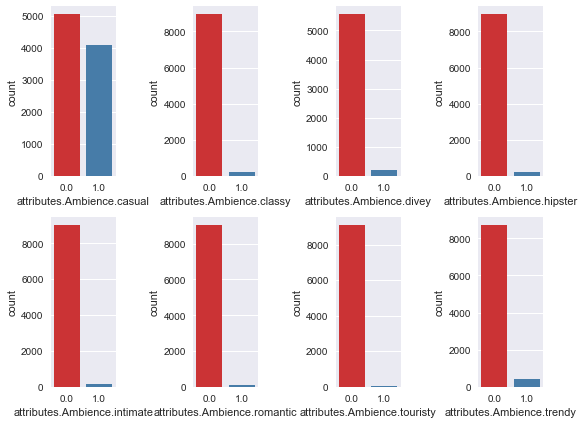

In [118]:
ambiencelist = yelp_attr.filter(like='attributes.Ambience').columns.tolist()
y = int(len(ambiencelist)/2)
fig, ax =plt.subplots(2, y, figsize=(8,6))
for i in range(2):
    for j in range(y):
        #print(i,j,ambiencelist[0])
        sns.countplot(yelp_attr[ambiencelist[0]], ax=ax[i,j], palette="Set1")
        del ambiencelist[0]
fig.tight_layout()        

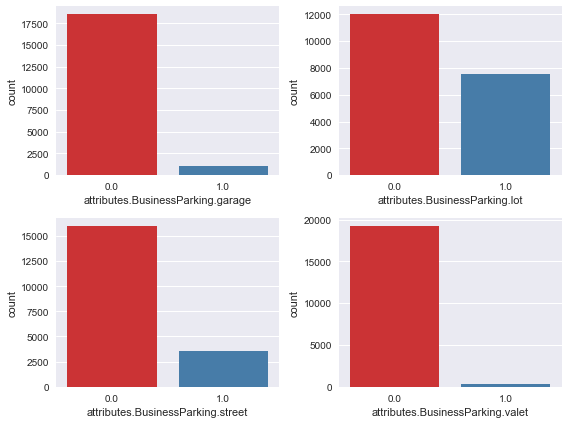

In [119]:
bplist = yelp_attr.filter(like='attributes.BusinessParking').columns.tolist()
y = int(len(bplist)/2)
fig, ax =plt.subplots(2, y, figsize=(8,6))
for i in range(2):
    for j in range(y):
        #print(i,j,ambiencelist[0])
        sns.countplot(yelp_attr[bplist[0]], ax=ax[i,j], palette="Set1")
        del bplist[0]
fig.tight_layout()        


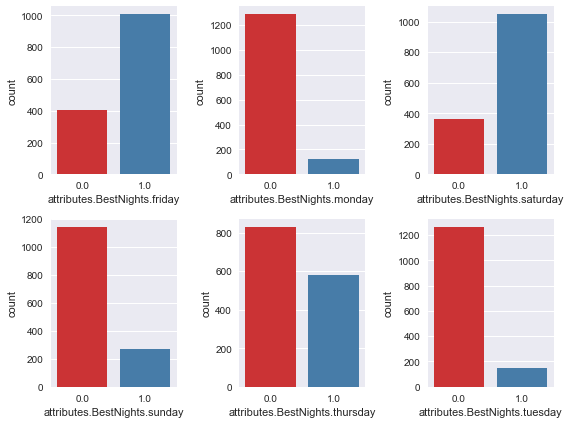

In [120]:
bnlist = yelp_attr.filter(like='attributes.BestNights').columns.tolist()
y = int(len(bnlist)/2)
fig, ax =plt.subplots(2, y, figsize=(8,6))
for i in range(2):
    for j in range(y):
        #print(i,j,ambiencelist[0])
        sns.countplot(yelp_attr[bnlist[0]], ax=ax[i,j], palette="Set1")
        del bnlist[0]
fig.tight_layout()        

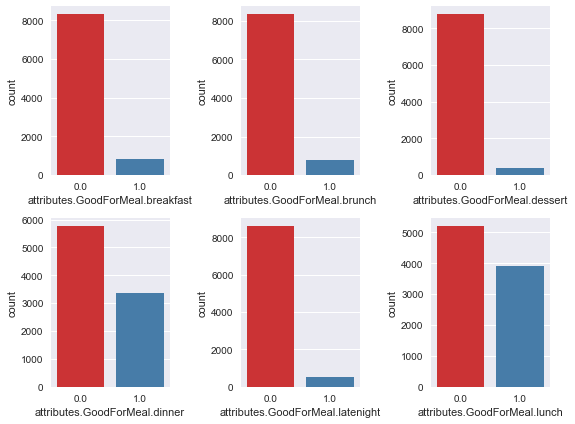

In [121]:
meallist = yelp_attr.filter(like='attributes.GoodForMeal').columns.tolist()
y = int(len(meallist)/2)
fig, ax =plt.subplots(2, y, figsize=(8,6))
for i in range(2):
    for j in range(y):
        sns.countplot(yelp_attr[meallist[0]], ax=ax[i,j], palette="Set1")
        del meallist[0]
fig.tight_layout()        


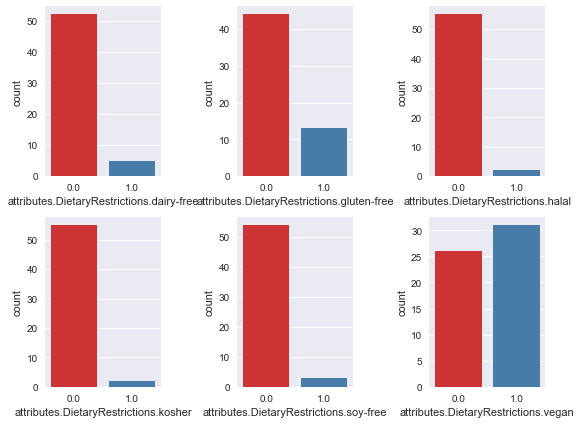

In [122]:
dtlist = yelp_attr.filter(like='attributes.DietaryRestrictions').columns.tolist()
y = int(len(dtlist)/2)
fig, ax =plt.subplots(2, y, figsize=(8,6))
for i in range(2):
    for j in range(y):
        sns.countplot(yelp_attr[dtlist[0]], ax=ax[i,j], palette="Set1")
        del dtlist[0]
fig.tight_layout()        

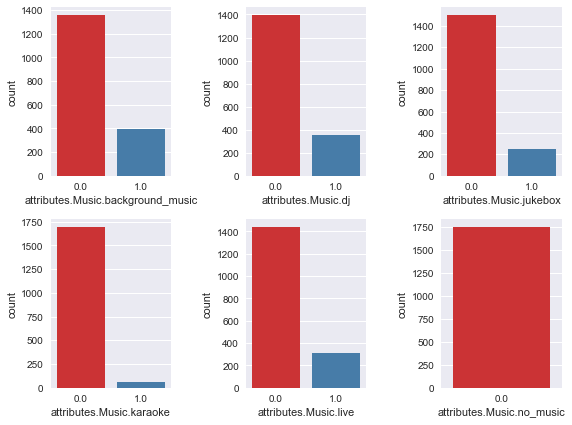

In [123]:
mlist = yelp_attr.filter(like='attributes.Music').columns.tolist()
y = int(len(mlist)/2)
fig, ax =plt.subplots(2, y, figsize=(8,6))
for i in range(2):
    for j in range(y):
        sns.countplot(yelp_attr[mlist[0]], ax=ax[i,j], palette="Set1")
        del mlist[0]
fig.tight_layout()        

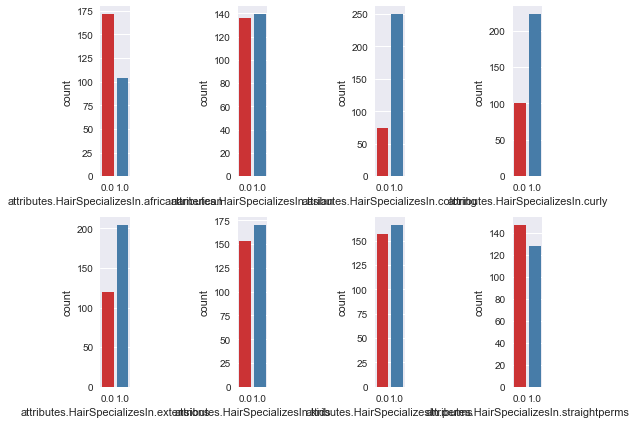

In [124]:
hlist = yelp_attr.filter(like='attributes.HairSpecializesIn').columns.tolist()
y = int(len(hlist)/2)
fig, ax =plt.subplots(2, y, figsize=(8,6))
for i in range(2):
    for j in range(y):
        sns.countplot(yelp_attr[hlist[0]], ax=ax[i,j], palette="Set1")
        del hlist[0]
fig.tight_layout()        

In [169]:
yelp_attr.to_csv('yelp_attr_sj.csv', encoding='utf-8', header=True, index=False)

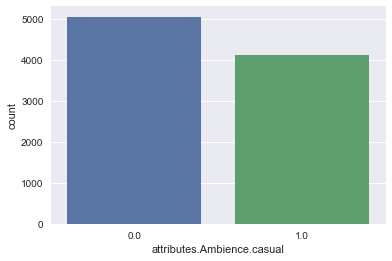

In [166]:
sns.countplot(yelp_attr['attributes.Ambience.casual'])

In [129]:
yelp_businessdf.head()

,business_id,cool,date_review,funny,review_id,stars_review,text_review,useful,user_id_review,name,...,neighborhood,categories,is_open,latitude,longitude,date_tip,likes,text_tip,user_id_tip,time
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw,NaN,...,NaN,NaN,NaN,NaN,NaN,2015-07-08,0.0,There's an extra charge for sharing.,Ua-4uhdy1iZhvrQ2oWWkUg,NaN
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,VR6GpWIda3SfvPC-lg9H3w,0,2016-05-28,0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw,Lester's Deli,...,Outremont,"[Specialty Food, Food, Sandwiches, Restaurants...",1.0,45.522144,-73.607076,NaT,NaN,NaN,NaN,NaN
4,ACFtxLv8pGrrxMm6EgjreA,0,2016-05-28,0,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [133]:
yelp_businessdf['categories'][yelp_businessdf['categories'].notnull()] = yelp_businessdf['categories'][yelp_businessdf['categories'].notnull()].apply(','.join)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [135]:
yelp_businessdf['categories'].head()

0                                                  NaN
1                                                  NaN
2                                                  NaN
3    Specialty Food,Food,Sandwiches,Restaurants,Bur...
4                                                  NaN
Name: categories, dtype: object

In [169]:
cat_list = set()
for sstr in yelp_businessdf['categories'][yelp_businessdf['categories'].notnull()].str.split(','):
    cat_list = set().union(sstr, cat_list)
cat_list = list(cat_list)
#cat_list.remove('')
cat_list

['Botanical Gardens',
 'Home Decor',
 'Pets',
 'Bowling',
 'Festivals',
 'Laser Hair Removal',
 'Sports Medicine',
 'Dim Sum',
 'German',
 'Medical Spas',
 'Imported Food',
 'Wine Bars',
 'Waffles',
 'American (New)',
 'Auto Parts & Supplies',
 'Educational Services',
 'Thrift Stores',
 'Interior Design',
 'Beer Bar',
 'Pilates',
 'Persian/Iranian',
 'Dry Cleaning & Laundry',
 'Cosmetic Surgeons',
 'Noodles',
 'Education',
 'Buses',
 'Physical Therapy',
 'Sushi Bars',
 'Acupuncture',
 'Hair Stylists',
 "Men's Clothing",
 'Vitamins & Supplements',
 'Supernatural Readings',
 'Japanese',
 'Brasseries',
 'Gay Bars',
 'Outlet Stores',
 'Russian',
 'Massage Therapy',
 'Golf',
 'Fondue',
 'Modern European',
 'Wine Tasting Room',
 'Creperies',
 'Orthopedists',
 'Food Court',
 'Pet Training',
 'Reiki',
 'Filipino',
 'Active Life',
 'Macarons',
 'Cideries',
 'Landmarks & Historical Buildings',
 'Tours',
 'Wedding Planning',
 'Acai Bowls',
 'Grocery',
 'Musical Instruments & Teachers',
 'Event Ph

In [170]:
len(cat_list)

538

In [171]:
yelp_businessdf['categories'].str.contains('Bike Rentals').sum()

1

In [172]:
cat_count = []
for cat in cat_list:
    cat_count.append([cat,yelp_businessdf['categories'].str.contains(cat).sum()])

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


### Top categories from yelp

In [183]:
names = ['cat_name','cat_count']
cat_df = pd.DataFrame(data=cat_count, columns=names)
cat_df.sort_values("cat_count", inplace=True, ascending=False)
cat_df.head(10)

,cat_name,cat_count
415,Restaurants,1611
319,Food,622
350,Bars,537
336,Nightlife,462
332,Hotels & Travel,207
436,Hotels,207
156,Breakfast & Brunch,205
405,Pizza,184
88,Event Planning & Services,179
234,Shopping,166


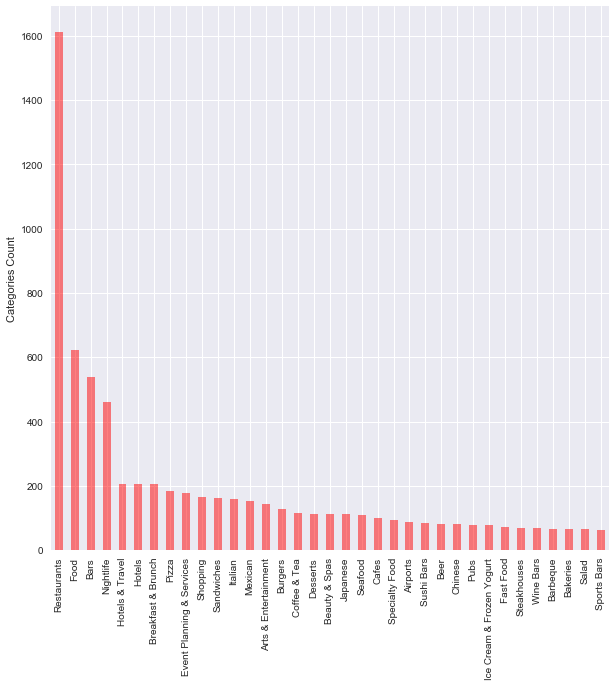

In [182]:
plt.subplots(figsize=(8, 8))
labels=cat_df['cat_name'][cat_df['cat_count']>60]
cat_df['cat_count'][cat_df['cat_count']>60].plot.bar( align='center', alpha=0.5, color='red')
y_pos = np.arange(len(labels))
#plt.yticks(y_pos, labels)
plt.xticks(y_pos, labels)
plt.ylabel('Categories Count')

### Cities that are reviewed the most

In [225]:
city_cnt = pd.DataFrame(yelp_businessdf['city'].value_counts()[:20])
state_cnt = pd.DataFrame(yelp_businessdf['state'].value_counts()[:20])

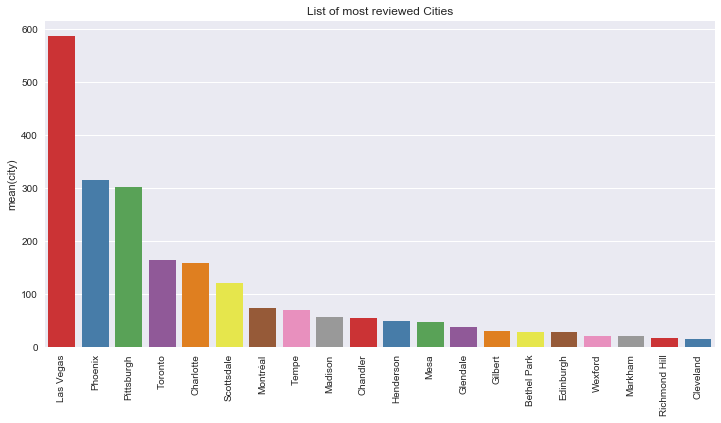

In [249]:
plt.figure(figsize=(12,6))
g = sns.barplot(x=city_cnt.index, y=city_cnt['city'], palette = 'Set1')
plt.title('List of most reviewed Cities');
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

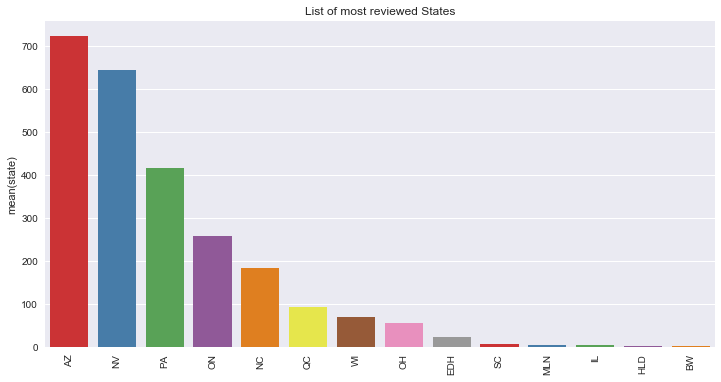

In [251]:
plt.figure(figsize=(12,6))
g = sns.barplot(x=state_cnt.index, y=state_cnt['state'], palette = 'Set1')
plt.title('List of most reviewed States');
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

# Business Ratings

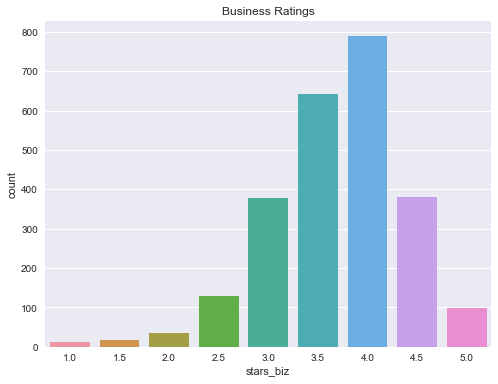

In [209]:
plt.figure(figsize=(8,6))
ax = sns.countplot(yelp_businessdf['stars_biz'])
plt.title('Business Ratings');

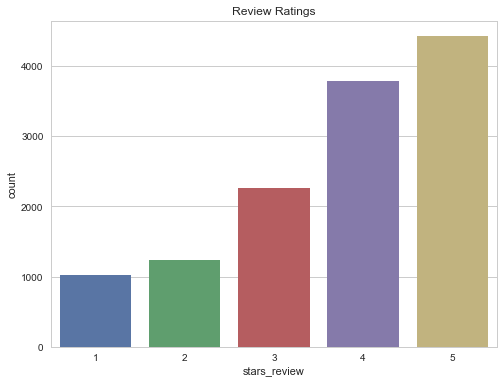

In [252]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
ax = sns.countplot(yelp_businessdf['stars_review'])
plt.title('Review Ratings');

In [253]:
#yelp_businessdf['stars_biz'].value_counts()

In [271]:
biz_cnt = pd.DataFrame(yelp_businessdf['name'].value_counts()[:20])

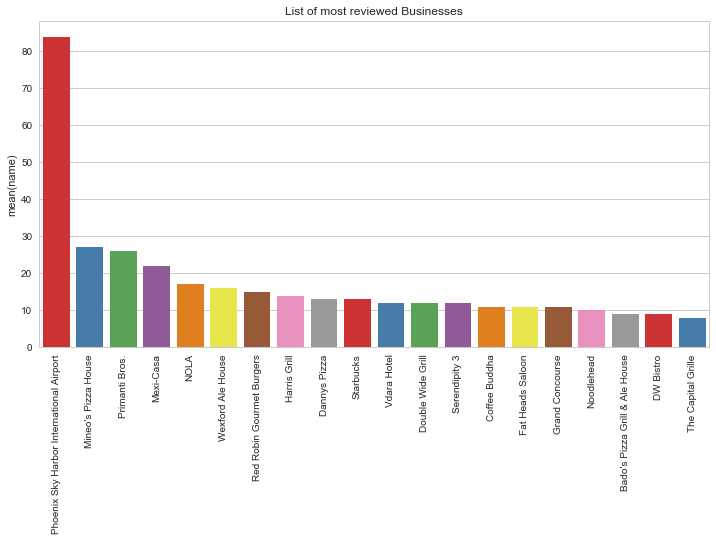

In [273]:
plt.figure(figsize=(12,6))
g = sns.barplot(x=biz_cnt.index, y=biz_cnt['name'], palette = 'Set1')
plt.title('List of most reviewed Businesses');
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

### TO BE CONTINUED
    - Different attributes and the businesses
    - Categories & businesses
    - What business has got more reviews
    - What kind of reviews
    - What were the main words in top reviews
    - What were the main words in top tips
    - Who is the top most reviewer
    - which states have got the more reviews from?
    - Is there a link that can be formed within the users? Is there a friend circle
    - What are the main attributes of the top most places reviewed? What is the price range? What kind of people visit those places?
    - What are the main categories of the business
